# Analysis of Films

## Overview

The purpose of this project is to analyze the trends in the movie industry and give reccommendations base on these initial findings to new studis. Exploratory analysis reveals the average ROI of ##, runtime averging closer to 2 hours, and action with other genres included produced the most revenue per movie. Microsoft can use the analysis made here to aid have a sense on they type of movies they should aim for in their new movie studio.

## Business Problem

Microsoft can venture into the movie industry by creating a movie studio under their name. The issue is that Microsoft may be unfamilar with where to being in the production of new films. With some insight into the landscape of the movie industry such as how much money others are investing per movie, the length of movies and the type of genres that produce high gross per movie, Microsoft will be able produce films that are profitable. This project decribes the trends in return of investment, movie length over time and top genres.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import sqlite3
import zipfile as zf
import os
pd.set_option('display.float_format', lambda x: '%.0f' % x)

Data

## Data Understanding

The data comes from multiple sources. In this project, data from the the box office, tmdb, tn and IMDB was used. Each data file had the name of the film in which merges occurred on as they each had an column of interest for the analysis. The data provide the production budget, worldwide gross, runtime and other features of a film that may be of interest. 

In [2]:
bom = pd.read_csv('./data/bom.movie_gross.csv.gz')
tmdb = pd.read_csv('./data/tmdb.movies.csv.gz')
tn = pd.read_csv('./data/tn.movie_budgets.csv.gz')
files = zf.ZipFile('./data/im.db.zip', 'r') #these lines create a im.db file which is too big to push
files.extractall() #these lines create a im.db file which is too big to push
con = sqlite3.connect("./im.db")

In [3]:
titles = pd.read_sql("""
Select * 

From movie_basics
            
""", con)
titles.head(1)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"


In [4]:
rating = pd.read_sql("""
Select * 

From movie_ratings
            
""", con)

rating.head(1)

,movie_id,averagerating,numvotes
0,tt10356526,8,31


In [5]:
#creation of the merged table betweeen bom and tmdb
rating_and_gross = bom.merge(tmdb, how='inner', left_on='title', right_on='title').sort_values('domestic_gross', ascending=False)

In [6]:
#creation of merge table of the rating_and_gross with the tn table
budget_rating_gross =   rating_and_gross.merge(tn, how='inner', left_on='title', right_on='movie')

In [7]:
sql_df = pd.read_sql('''
    SELECT *
    
    FROM
    movie_ratings
    
    INNER JOIN movie_basics
        USING(movie_id) 
     
     WHERE numvotes >= 1000
     
     ORDER BY 
         averagerating DESC
''', con)

#We need to choose and averagerating number for a WHERE clause
#If we feel like we need more ratings data we can combine this with budget_rating_gross

## Data Preparation

In [78]:
budget_rating_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   domestic_gross_x   1393 non-null   float64
 3   foreign_gross      1200 non-null   object 
 4   year               1395 non-null   int64  
 5   Unnamed: 0         1395 non-null   int64  
 6   genre_ids          1395 non-null   object 
 7   id_x               1395 non-null   int64  
 8   original_language  1395 non-null   object 
 9   original_title     1395 non-null   object 
 10  popularity         1395 non-null   float64
 11  release_date_x     1395 non-null   object 
 12  vote_average       1395 non-null   float64
 13  vote_count         1395 non-null   int64  
 14  id_y               1395 non-null   int64  
 15  release_date_y     1395 non-null   object 
 16  movie              1395 

There are 195 null values in the foreign_gross column, 2 in the domestic_gross_x column, and 1 in studio column.
There are duplicate and unnecessary columns. 

In [8]:
#dropping unnecessary columns
clean_columns = budget_rating_gross.drop(['release_date_y', 'Unnamed: 0', 'genre_ids', 'original_title', 'domestic_gross_x', 'foreign_gross', 'movie', 'id_x', 'id_y', 'original_language'], axis=1)
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   year               1395 non-null   int64  
 3   popularity         1395 non-null   float64
 4   release_date_x     1395 non-null   object 
 5   vote_average       1395 non-null   float64
 6   vote_count         1395 non-null   int64  
 7   production_budget  1395 non-null   object 
 8   domestic_gross_y   1395 non-null   object 
 9   worldwide_gross    1395 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 119.9+ KB


In [9]:
#cleaning and converting worldwide_gross into int
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace('$', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace(',', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].astype(int)

In [86]:
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].str.replace('$', '')
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].str.replace(',', '')
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].astype(int)

In [87]:
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace('$', '')
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace(',', '')
clean_columns['production_budget'] = clean_columns['production_budget'].astype(int)

In [88]:
#Sanity Check
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   year               1395 non-null   int64  
 3   popularity         1395 non-null   float64
 4   release_date_x     1395 non-null   object 
 5   vote_average       1395 non-null   float64
 6   vote_count         1395 non-null   int64  
 7   production_budget  1395 non-null   int64  
 8   domestic_gross_y   1395 non-null   int64  
 9   worldwide_gross    1395 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 119.9+ KB


In [ ]:
#dropping exact row duplicates
test_clean_columns = clean_columns.drop_duplicates()

In [ ]:
#dropping duplicates where the title name is the same but other values are wrong
vote_count_max = test_clean_columns.groupby(['title','studio']).vote_count.transform(max)
movies_clean = test_clean_columns.loc[test_clean_columns.vote_count == vote_count_max]

In [ ]:
#Sanity Check: verifying the shape of movies_clean
movies_clean.shape

# Data Analyzation

In [ ]:
#Quick glance at the information of the dataset
movies_clean.describe()
# min value for production_budget is > 0.

In [ ]:
#Dropping outliers from worldwide_gross
q3, q1 = np.percentile(movies_clean['worldwide_gross'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_wwg = movies_clean['worldwide_gross'].mean()-(iqr*1.5)

upper_limit_wwg = movies_clean['worldwide_gross'].mean()+(iqr*1.5)

lower_limit_wwg, upper_limit_wwg

In [ ]:
movies_without_wwg_outliers = movies_clean[movies_clean['worldwide_gross']<upper_limit_wwg]

In [ ]:
#Dropping outliers from production_budget
q3, q1 = np.percentile(movies_without_wwg_outliers['production_budget'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_pb = movies_without_wwg_outliers['production_budget'].mean()-(iqr*1.5)

upper_limit_pb = movies_without_wwg_outliers['production_budget'].mean()+(iqr*1.5)

lower_limit_pb, upper_limit_pb

In [ ]:
movies_without_wwg_or_pb_outliers = movies_without_wwg_outliers[movies_without_wwg_outliers['production_budget']<upper_limit_pb]

# Production Budget

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'], alpha = .4)

ax.set_title('Production Budget and Worldwide Gross')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross');

#checking the correlation coefficient of movies_without_wwg_or_pb_outliers
np.corrcoef(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'])
#postive correlation but not as strong as the movie_oultierless

# Movie Genre

In [ ]:
#genres vs averagerating
genres_average_rating = sql_df.groupby(['genres']).mean(['averagerating']).sort_values(['averagerating'], ascending=False).head(20)
genres_average_rating
#Low vote counts

# Runtime

# Avenues to Explore

# Junk

In [17]:
#addition of gross to production budget ratio
#Rename gross_to_budget_ratio to ROI or something more appropriate.
clean_columns['gross_to_budget_ratio'] = clean_columns['worldwide_gross'] / clean_columns['production_budget']

In [18]:
#sorting values by gross_to_budget 
clean_columns.sort_values(by='gross_to_budget_ratio', ascending=False)

,title,studio,year,original_language,popularity,release_date_x,vote_average,vote_count,release_date_y,production_budget,domestic_gross_y,worldwide_gross,foreign_gross,gross_to_budget_ratio
824,The Gallows,WB (NL),2015,en,9.166,2015-07-10,4.8,591,"Jul 10, 2015",100000,22764410,41656474,18892064,416.564740
499,The Devil Inside,Par.,2012,en,7.403,2012-01-06,4.7,441,"Jan 6, 2012",1000000,53262945,101759490,48496545,101.759490
496,Insidious,FD,2011,en,16.197,2011-04-01,6.9,3582,"Apr 1, 2011",1500000,54009150,99870886,45861736,66.580591
712,Unfriended,Uni.,2015,en,8.120,2015-04-17,5.4,2019,"Apr 17, 2015",1000000,32789645,64364198,31574553,64.364198
312,Paranormal Activity 2,Par.,2010,en,8.163,2010-10-21,5.7,1342,"Oct 20, 2010",3000000,84752907,177512032,92759125,59.170677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,Eden,BG,2015,en,0.600,2018-11-25,0.0,1,"Jan 19, 2016",2300000,0,0,0,0.000000
1348,Eden,BG,2015,en,5.373,2015-06-19,5.8,57,"Jan 19, 2016",2300000,0,0,0,0.000000
592,Snitch,LG/S,2013,en,16.673,2013-02-22,5.9,1493,"Dec 31, 2012",850000,0,0,0,0.000000
1349,Eden,BG,2015,en,5.373,2015-06-19,5.8,57,"Jan 19, 2016",2300000,0,0,0,0.000000


In [22]:
#sorting dataframe by gross_to_budget_ratio
movies_clean.sort_values(['gross_to_budget_ratio'], ascending=False)

,title,studio,year,original_language,popularity,release_date_x,vote_average,vote_count,release_date_y,production_budget,domestic_gross_y,worldwide_gross,foreign_gross,gross_to_budget_ratio
824,The Gallows,WB (NL),2015,en,9.166,2015-07-10,4.8,591,"Jul 10, 2015",100000,22764410,41656474,18892064,416.564740
499,The Devil Inside,Par.,2012,en,7.403,2012-01-06,4.7,441,"Jan 6, 2012",1000000,53262945,101759490,48496545,101.759490
496,Insidious,FD,2011,en,16.197,2011-04-01,6.9,3582,"Apr 1, 2011",1500000,54009150,99870886,45861736,66.580591
712,Unfriended,Uni.,2015,en,8.120,2015-04-17,5.4,2019,"Apr 17, 2015",1000000,32789645,64364198,31574553,64.364198
312,Paranormal Activity 2,Par.,2010,en,8.163,2010-10-21,5.7,1342,"Oct 20, 2010",3000000,84752907,177512032,92759125,59.170677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,Skin Trade,Magn.,2015,en,9.362,2014-11-07,5.6,96,"May 8, 2015",9000000,1242,1242,0,0.000138
1346,Eden,BG,2015,en,6.877,2012-03-11,6.8,100,"Jan 19, 2016",2300000,0,0,0,0.000000
1182,Trance,FoxS,2013,en,9.571,2013-04-05,6.6,1348,"Dec 31, 2012",950000,0,0,0,0.000000
1273,Point Blank,Magn.,2011,fr,6.021,2011-07-29,6.6,230,"Sep 18, 1967",3000000,0,0,0,0.000000


In [23]:
#verifying that there's no null values
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 0 to 1394
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  1178 non-null   object 
 1   studio                 1178 non-null   object 
 2   year                   1178 non-null   int64  
 3   original_language      1178 non-null   object 
 4   popularity             1178 non-null   float64
 5   release_date_x         1178 non-null   object 
 6   vote_average           1178 non-null   float64
 7   vote_count             1178 non-null   int64  
 8   release_date_y         1178 non-null   object 
 9   production_budget      1178 non-null   int64  
 10  domestic_gross_y       1178 non-null   int64  
 11  worldwide_gross        1178 non-null   int64  
 12  foreign_gross          1178 non-null   int64  
 13  gross_to_budget_ratio  1178 non-null   float64
dtypes: float64(3), int64(6), object(5)
memory usage: 138.0+ 

In [26]:
#MAke to help determining bounds of the graph
q3, q1 = np.percentile(movies_clean['gross_to_budget_ratio'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit = movies_clean['gross_to_budget_ratio'].mean()-(iqr*1.5)

upper_limit = movies_clean['gross_to_budget_ratio'].mean()+(iqr*1.5)

lower_limit, upper_limit

(-0.2697839574098566, 9.106872819728032)

In [27]:
#limiting data to the upper limit of the iqr
movies_oultierless = movies_clean[movies_clean['gross_to_budget_ratio']<upper_limit]
movies_oultierless

,title,studio,year,original_language,popularity,release_date_x,vote_average,vote_count,release_date_y,production_budget,domestic_gross_y,worldwide_gross,foreign_gross,gross_to_budget_ratio
0,Black Panther,BV,2018,en,44.140,2018-02-16,7.4,12365,"Feb 16, 2018",200000000,700059566,1348258224,648198658,6.741291
2,Avengers: Infinity War,BV,2018,en,80.773,2018-04-27,8.3,13948,"Apr 27, 2018",300000000,678815482,2048134200,1369318718,6.827114
3,Jurassic World,Uni.,2015,en,20.709,2015-06-12,6.6,14056,"Jun 12, 2015",215000000,652270625,1648854864,996584239,7.669092
4,Incredibles 2,BV,2018,en,36.286,2018-06-15,7.6,6354,"Jun 15, 2018",200000000,608581744,1242520711,633938967,6.212604
5,Rogue One: A Star Wars Story,BV,2016,en,21.401,2016-12-16,7.5,9296,"Dec 16, 2016",200000000,532177324,1049102856,516925532,5.245514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,Skin Trade,Magn.,2015,en,9.362,2014-11-07,5.6,96,"May 8, 2015",9000000,1242,1242,0,0.000138
1390,Khumba,MNE,2013,en,9.597,2013-12-07,5.6,129,"Dec 6, 2013",15000000,0,20898221,20898221,1.393215
1391,Jackpot,DR,2014,no,2.864,2014-06-27,6.1,18,"Jul 27, 2001",400000,44452,44452,0,0.111130
1393,It's a Wonderful Afterlife,UTV,2010,en,1.332,2010-10-08,4.6,12,"Oct 8, 2010",10000000,0,1642939,1642939,0.164294


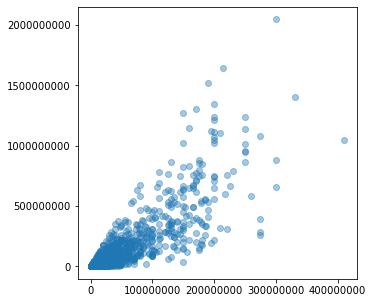

In [89]:
#graph of movies_oultierless
fig, ax = plt.subplots(figsize=(5,5),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'], alpha = .4);
#Removed outliers based on gross_to_budget_ratio. The correlation was very strong and positive.
np.corrcoef(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'])
#almost a 1:1 correlation

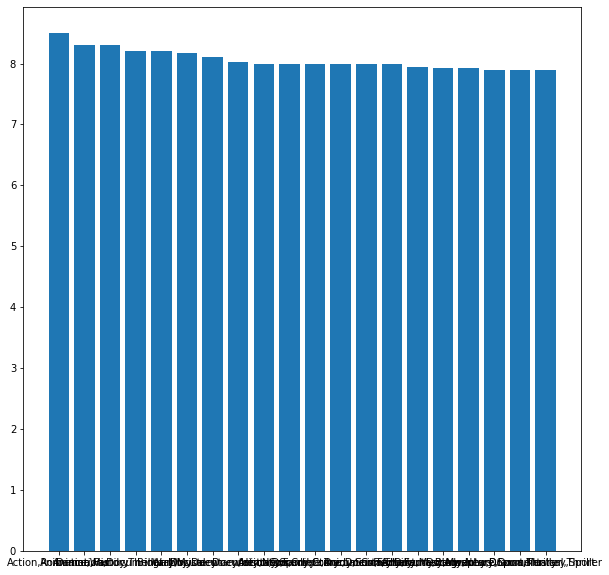

In [66]:
fig, ax = plt.subplots(figsize=(10,10))

ax.bar(x=genres_average_rating.index.astype(str), height=genres_average_rating['averagerating']);

In [67]:
#runtime_minutes vs start_year
runtime_year = sql_df.groupby(['start_year']).mean(['runtime_minutes']).sort_values(['start_year'])
runtime_year

,averagerating,numvotes,runtime_minutes
start_year,,,
2010,6.306378,32207.062703,104.954545
2011,6.209054,32552.066124,103.919634
2012,6.180998,30643.207294,103.789625
2013,6.231584,31468.162896,105.320943
2014,6.227380,28236.682393,104.743892
2015,6.241098,22376.908769,104.757764
2016,6.240018,22988.199642,106.046637
2017,6.238200,19243.393939,106.879706
2018,6.368102,18289.530850,109.436554


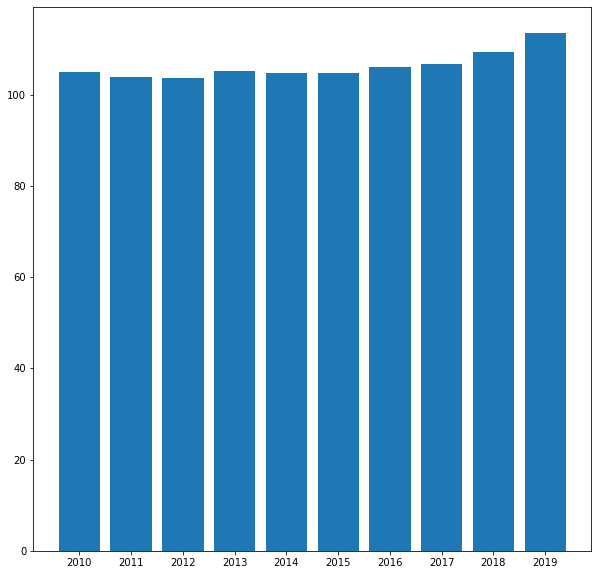

In [68]:
fig, ax = plt.subplots(figsize=(10,10))

ax.bar(x=runtime_year.index.astype(str), height=runtime_year['runtime_minutes']);

In [69]:
#stong positive correlation
#movies are getting longer!
np.corrcoef(runtime_year.index , y = runtime_year['runtime_minutes'])

array([[1.        , 0.81055676],
       [0.81055676, 1.        ]])

In [70]:
con.close() #have this in case file refuses to close

In [71]:
os.remove('im.db') #This line deletes the im.db file created earlier.